## 2.1 Modeling marketable yield
### The data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import time # Afficher la durée à l'optimisation
np.random.seed(seed = 505730)

Custom function to generate a grid with all possible combinations of vectors in a dictionnary (source: [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html?highlight=expand_grid#creating-example-data)).

In [2]:
import itertools
def expand_grid(data_dict):
   rows = itertools.product(*data_dict.values())
   return pd.DataFrame.from_records(rows, columns = data_dict.keys())

Load data.

In [3]:
df_ml = pd.read_csv('output/df_RendVend.csv')
df_ml.columns

Index(['RendVendable', 'NoEssai', 'NoBloc', 'NoTraitement', 'ID', 'ID_bl',
       'DensitePlants', 'PrecCropFiveClasses', 'Cultivar', 'Maturity5',
       'growing.season', 'temp_moy_5years', 'prec_tot_5years', 'sdi_5years',
       'gdd_5years', 'NtotDose', 'PtotDose', 'KtotDose', 'soilTextIlr1',
       'soilTextIlr2', 'soilTextIlr3', 'soilTypeIlr1_3', 'soilTypeIlr2_3',
       'soil_pH', 'soil_P1_Fv.AlP', 'soil_P1_Al.P', 'soil_K2_FvMgCa.K',
       'soil_K2_Fv.MgCa', 'soil_K2_Mg.Ca', 'soil_P', 'soil_K', 'soil_Al',
       'ISP1', 'test_type'],
      dtype='object')

In [4]:
common_df = pd.read_csv('output/common_df.csv') # to identify reference trials later.

I create vectors categorizing response and predictors.

In [5]:
num_vars = ['DensitePlants', 'growing.season',
            'temp_moy_5years', 'prec_tot_5years', 'sdi_5years', 'gdd_5years',
            'NtotDose', 'PtotDose', 'KtotDose',
            'soilTextIlr1', 'soilTextIlr2', 'soilTextIlr3',
            'soilTypeIlr1_3', 'soilTypeIlr2_3',
            'soil_pH', 
            'soil_P1_Fv.AlP', 'soil_P1_Al.P', 'soil_K2_FvMgCa.K', 'soil_K2_Fv.MgCa', 'soil_K2_Mg.Ca']
cat_vars = ['PrecCropFiveClasses']
resp_vars = ['RendVendable']
dose_vars = ['NtotDose', 'PtotDose', 'KtotDose']

In __N__ tests, __P__ and __K__ doses are in excess, which drags recommandations upwards. In all N tests, we set the __P__ and __K__ doses according to the CRAAQ fertilisation guide. The next cells are used to correct abnormally high non-limiting __P__ and __K__ dosage for some trials.

In [6]:
def craaq_P(x): # x, ISP
    if x <= 2.5:
        recommandation = 200
    elif x <= 5:
        recommandation = 150
    elif x <= 10:
        recommandation = 150
    elif x <= 15:
        recommandation = 120
    elif x <= 25:
        recommandation = 75
    else:
        recommandation = 50
    return recommandation

In [7]:
def craaq_K(x): # x, K in kg K_M3 / ha
    if x <= 75:
        recommandation = 240
    elif x <= 150:
        recommandation = 215
    elif x <= 225:
        recommandation = 160
    elif x <= 300:
        recommandation = 120
    elif x <= 375:
        recommandation = 80
    elif x <= 450:
        recommandation = 50
    else:
        recommandation = 20
    return recommandation

In [8]:
df_ml.loc[df_ml.test_type == 'N', "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))
df_ml.loc[df_ml.test_type == 'N', "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x)) 

df_ml.loc[df_ml.test_type.isna(), "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))
df_ml.loc[df_ml.test_type.isna(), "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x)) 

df_ml.loc[df_ml.test_type == 'P', "KtotDose"] = df_ml.soil_K.apply(lambda x: craaq_K(x))
df_ml.loc[df_ml.test_type == 'K', "PtotDose"] = df_ml.ISP1.apply(lambda x: craaq_P(x))

Verify max doses per element: N-P-K respectively, and drop other useless columns (related to soil elements and trial identifiers).

In [9]:
np.max(df_ml.NtotDose), np.max(df_ml.PtotDose), np.max(df_ml.KtotDose)

(260.0, 300.0, 420.0)

In [10]:
id_table = df_ml[['ID', 'NoEssai', 'NoBloc','ID_bl', 'NoTraitement', 'test_type']]
id_table.index = df_ml.index
soil_table = df_ml[['soil_P', 'soil_Al', 'soil_K', 'ISP1']]
soil_table.index = df_ml.index
df_ml = df_ml.drop(['ID', 'NoEssai', 'NoBloc', 'ID_bl', 'NoTraitement', 'soil_P', 'soil_Al', 'soil_K', 'ISP1'], axis = 1)

I use the `panda.get_dummies()` function to transform each categorical feature with **m** possible values into **m** binary features, *with only one active*. The output will be a sparse matrix where each column corresponds to one possible value of one feature: one (__1__) indicates category membership; otherwise zero (__0__) is indicated.

In [11]:
df_ml["PrecCropFiveClasses"] = df_ml["PrecCropFiveClasses"].astype('category')
df_ml["test_type"] = df_ml["test_type"].astype('category')
df_ml["Cultivar"] = df_ml["Cultivar"].astype('category')
df_ml["Maturity5"] = df_ml["Maturity5"].astype('category')

In [12]:
df_ml = pd.get_dummies(df_ml, columns = ["PrecCropFiveClasses"])
df_ml = pd.get_dummies(df_ml, columns = ["test_type"])
df_ml = pd.get_dummies(df_ml, columns = ["Cultivar"])
df_ml = pd.get_dummies(df_ml, columns = ["Maturity5"])

If `test_type`, `Cultivar` or `Maturity5` variables should be removed before modeling, the next cell is activated or not:

In [13]:
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('test_type')]
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('Cultivar')]
df_ml = df_ml.loc[:, ~df_ml.columns.str.startswith('Maturity5')]

### Data set __train__ and __test__ split

If we need to predict a whole dose-response curve, we need to split by trials.

The split proportions are set to obtain __~70% of data__ in the training set. This kind of split is the most robust since the training and test sets are independant data. I split at _bloc level_. This split allows to mix data from the same experimental plots, but on different blocks. Data in both sets are independant, but because blocks are similar units the model might behave wrongly on new sites with less usual data.

In [14]:
np.random.seed(seed=48327)
blocks = id_table['ID_bl']
N_blocks = blocks[id_table.test_type == 'N'].unique()
N_blocks_inTrain = np.random.choice(a = N_blocks, 
                                    size = np.around(0.7 * len(N_blocks)).astype(int), 
                                    replace = False)

P_blocks = blocks[id_table.test_type == 'P'].unique()
P_blocks_inTrain = np.random.choice(a = P_blocks, 
                                    size = np.around(0.7 * len(P_blocks)).astype(int), 
                                    replace = False)

K_blocks = blocks[id_table.test_type == 'K'].unique()
K_blocks_inTrain = np.random.choice(a = K_blocks, 
                                    size = np.around(0.7 * len(K_blocks)).astype(int), 
                                    replace = False)

npk_blocks = blocks[id_table.test_type == 'NPK'].unique()
npk_blocks_inTrain = np.random.choice(a = npk_blocks, 
                                      size = np.around(len(npk_blocks) * 0.7).astype(int), 
                                      replace = False)

na_blocks = blocks[id_table.test_type.isna()].unique()
na_blocks_inTrain = np.random.choice(a = na_blocks, 
                                     size = np.around(len(na_blocks) * 0.7).astype(int), 
                                     replace = False)

In [15]:
blocks_inTrain = np.concatenate([N_blocks_inTrain, 
                                 P_blocks_inTrain, 
                                 K_blocks_inTrain, 
                                 npk_blocks_inTrain, 
                                 na_blocks_inTrain])

blocks_inTest = blocks[~blocks.isin(blocks_inTrain)].unique()

Numerical variables are scaled before modeling. Both predictive and response variables are set to null (__0__) mean and unit (__1__) variance using the training set mean and standard error. This chunk computes the mean and standard error of predictive variables.

In [16]:
mean_numvars = df_ml.loc[blocks.isin(blocks_inTrain), num_vars].apply(axis = 0, func = np.mean)
std_numvars = df_ml.loc[blocks.isin(blocks_inTrain), num_vars].apply(axis = 0, func = np.std)
df_ml_sc = df_ml.copy()
for var in num_vars:
    df_ml_sc[var] = (df_ml[var] - df_ml.loc[blocks.isin(blocks_inTrain), var].mean()) / df_ml.loc[blocks.isin(blocks_inTrain), var].std()

The response is also scaled:

In [17]:
mean_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].mean()
std_respvars = df_ml.loc[blocks.isin(blocks_inTrain), resp_vars].std()
for var in resp_vars:
    df_ml_sc[var] = (df_ml[var] - mean_respvars[var]) / std_respvars[var]

Then, separate train and test arrays are created for predictive and response variables.

In [18]:
X_train = df_ml_sc.loc[blocks.isin(blocks_inTrain), df_ml.columns.isin(num_vars) | df_ml.columns.str.startswith(cat_vars[0])].values
X_test = df_ml_sc.loc[~blocks.isin(blocks_inTrain), df_ml.columns.isin(num_vars) | df_ml.columns.str.startswith(cat_vars[0])].values
Y_train = df_ml_sc[resp_vars][blocks.isin(blocks_inTrain)].values
Y_test = df_ml_sc[resp_vars][~blocks.isin(blocks_inTrain)].values

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4139, 25), (1774, 25), (4139, 1), (1774, 1))

Let's check the proportion of data in the traning set:

In [20]:
round(df_ml.loc[blocks.isin(blocks_inTrain)].shape[0]/df_ml.shape[0], 3)

0.7

### Feature importance

I use the python scikit-learn _ExtraTreesRegressor_ algorithm to select features that contributed most as predictive variables. The process ranks features importance.

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
import altair as alt
fs_reg = ExtraTreesRegressor(n_estimators=50)
fs_reg.fit(X_train, Y_train.ravel())

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=50, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

There is a need to show column names in English rather than their names in the data frame. We created a `csv` as translation table (`translate_col2.csv`). This table is merged to the variable importance table, which is then ranked and plotted.

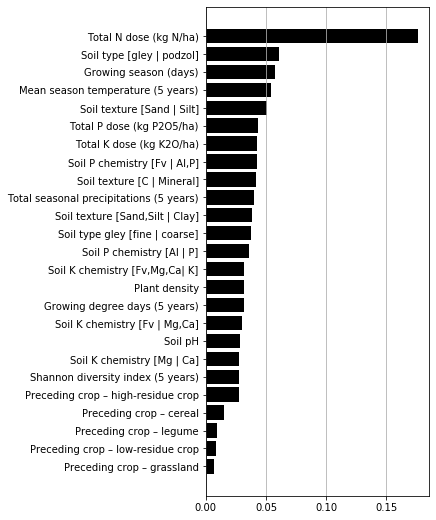

In [25]:
rf_varimp = pd.DataFrame({'columns': df_ml_sc.drop('RendVendable', axis = 1).columns,
             'importance': fs_reg.feature_importances_})
translate_columns = pd.read_csv("data/translate_col2.csv")
rf_varimp_en = pd.merge(rf_varimp,
                        translate_columns.drop("fr", axis = 1),
                        on = "columns", how = 'left').\
  sort_values(by = ["importance"])

plt.figure(figsize = (4, 9))
plt.barh(rf_varimp_en.en, rf_varimp_en.importance, color = "black");
plt.grid(axis = 'x')

In [26]:
rf_varimp_en.to_csv('output/varImp_yield.csv', index_label = "ID")

The preceeding crop categories could be removed.

In [27]:
remove_var_names = ['PrecCropFiveClasses_Cereal',
                    'PrecCropFiveClasses_Grassland',
                    'PrecCropFiveClasses_HRC',
                    'PrecCropFiveClasses_LRC',
                    'PrecCropFiveClasses_Legume']
keep_vars = ~ df_ml_sc.drop('RendVendable', axis = 1).columns.isin(remove_var_names)
X_train = X_train[:, keep_vars]
X_test = X_test[:, keep_vars]

In [28]:
pd.DataFrame(X_train, columns = df_ml_sc.drop('RendVendable', axis = 1).columns[keep_vars]).to_csv("output/x_train.csv", index=False)
pd.DataFrame(X_test, columns = df_ml_sc.drop('RendVendable', axis = 1).columns[keep_vars]).to_csv("output/x_test.csv", index=False)

pd.DataFrame(Y_train, columns = ['RendVendable']).to_csv("output/y_train.csv", index=False)
pd.DataFrame(Y_test, columns = ['RendVendable']).to_csv("output/y_test.csv", index=False)

In [29]:
id_table.loc[blocks.isin(blocks_inTrain), :].to_csv("output/train_id_table.csv", index=False)
id_table.loc[~blocks.isin(blocks_inTrain), :].to_csv("output/test_id_table.csv", index=False)

In [30]:
mean_numvars.to_csv("output/mean_numvars.csv", index=False)
std_numvars.to_csv("output/std_numvars.csv", index=False)
mean_respvars.to_csv("output/mean_respvars.csv", index=False)
std_respvars.to_csv("output/std_respvars.csv", index=False)

### Modeling
#### _General packages_

In [31]:
#from sklearn.model_selection import GridSearchCV # Grid Search
from sklearn.model_selection import RandomizedSearchCV # Random Search
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pprint import pprint # print default parameters of models

### k-nearest neighbors (knn) algorithm
#### _The default parameters_

In [32]:
from sklearn.neighbors import KNeighborsRegressor

In [33]:
knn_reg = KNeighborsRegressor()
print('Parameters currently in use:\n')
pprint(knn_reg.get_params())

Parameters currently in use:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


#### _Optimisation (paraneters tuning)_
A list of values to choose from should be given to each hyper parameter of the model. You can change these values and experiment more to see which value ranges give better performance. A cross validation process is performed in order to determine the hyper parameter value set which provides the best accuracy levels.

In [34]:
knn_param = {'n_neighbors': np.arange(3, 20), 
             'weights': ['uniform', 'distance']}
n_iter_search = 30

In [35]:
print("\nRunning random search to tune up KNN hyperparameters ...")
np.random.seed(seed = 48327)
start_time = time.time()
knn_random_search = RandomizedSearchCV(estimator = knn_reg, param_distributions = knn_param, n_iter = n_iter_search, cv = 5, n_jobs = -1)
knn_random_search.fit(X_train, Y_train)
print("Duration: %s secondes ---" % (time.time() - start_time))
knn_random_search.best_estimator_


Running random search to tune up KNN hyperparameters ...
Duration: 8.872263431549072 secondes ---


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                    weights='distance')

In [36]:
knn_random_search.best_params_

{'weights': 'distance', 'n_neighbors': 19}

#### _The __knn__ optimal model_

In [37]:
knn_reg = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                              metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                              weights='distance')
knn = knn_reg.fit(X_train, Y_train)

Performance in train and test

In [38]:
Y_train_obs = df_ml[resp_vars][blocks.isin(blocks_inTrain)].values
Y_test_obs = df_ml[resp_vars][~blocks.isin(blocks_inTrain)].values

In [39]:
Y_train_predknn = knn.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predknn = knn.predict(X_test) * std_respvars.values + mean_respvars.values

In [40]:
index = ['k-nearest neighbors']
knn_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, knn.predict(X_train)).round(3),
                           "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predknn).round(2),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predknn)).round(2),
                           "Test_R2": r2_score(Y_test, knn.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predknn).round(2),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predknn)).round(2)}, 
                           index = index)
knn_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
k-nearest neighbors,0.917,1.6,2.89,0.521,5.5,7.27


In [41]:
#test_std_resp = df_ml.loc[~blocks.isin(blocks_inTrain), resp_vars].std()
#test_std_resp/2

The __knn__ ressults plot

Text(0.5, 1.0, 'Test')

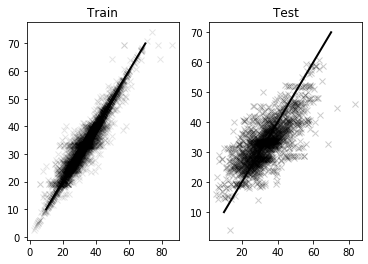

In [42]:
plt.subplot(1, 2, 1)
plt.plot(Y_train * std_respvars.values + mean_respvars.values, knn.predict(X_train)* std_respvars.values + mean_respvars.values, 
         marker = 'x', color = 'black', linestyle = 'None', alpha = 0.1)
plt.plot([10, 70], [10, 70], color = 'black', linewidth = 2)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.plot(Y_test * std_respvars.values + mean_respvars.values, knn.predict(X_test)* std_respvars.values + mean_respvars.values, 
         marker = 'x', color = 'black', linestyle = 'None', alpha = 0.2)
plt.plot([10, 70], [10, 70], color = 'black', linewidth = 2)
plt.title('Test')

### Random forest (RF) algorithm
#### _The default parameters_

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
rf_reg = RandomForestRegressor(random_state = 1)
print('Parameters currently in use:\n')
pprint(rf_reg.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


#### _Optimisation_
The most important settings are the number of trees in the forest (`n_estimators`) and the number of features considered for splitting at each leaf node (`max_features`). The `max_features` is set to its default value `'auto'`, while I try out a wide range of values to see what works for `n_estimators`.

#### _The best parameters_
The best parameters from fitting the random search could be viewed with `rf_random_search.best_params_` :

#### _The optimal model_

In [45]:
rf_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=92,
                               n_jobs=None, oob_score=False, random_state=1, verbose=0,
                               warm_start=False)
rfm = rf_reg.fit(X_train, Y_train.ravel())

Performance in train and test (rfm)

In [46]:
Y_train_predrf = rfm.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predrf =  rfm.predict(X_test) * std_respvars.values + mean_respvars.values

In [47]:
index = ['Random forest']
rf_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, rfm.predict(X_train)).round(3), 
                          "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predrf).round(2),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predrf)).round(2),
                           "Test_R2": r2_score(Y_test, rfm.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predrf).round(2),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predrf)).round(2)}, 
                          index = index)
rf_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Random forest,0.898,2.29,3.21,0.592,5.07,6.72


The __rf__ ressults plot

Text(0.5, 1.0, 'Testing')

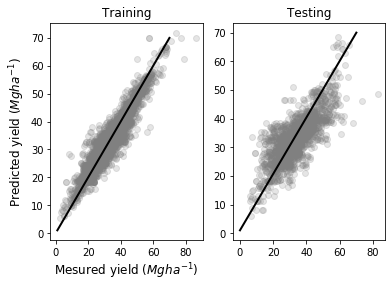

In [48]:
#fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(Y_train * std_respvars.values + mean_respvars.values, rfm.predict(X_train) * std_respvars.values + mean_respvars.values, 
         marker = 'o', color = 'grey', linestyle = 'None', alpha = 0.2)
plt.plot([1, 70], [1, 70], color = 'black', linewidth = 2)
plt.title('Training', fontsize = 12)
plt.xlabel(r'Mesured yield ($Mg ha^{-1})$', fontsize = 12)
plt.ylabel(r'Predicted yield ($Mg ha^{-1})$', fontsize = 12)

plt.subplot(1, 2, 2)
plt.plot(Y_test * std_respvars.values + mean_respvars.values, rfm.predict(X_test) * std_respvars.values + mean_respvars.values, 
         marker = 'o', color = 'grey', linestyle = 'None', alpha = 0.2)
plt.plot([0, 70], [1, 70], color = 'black', linewidth = 2)
plt.title('Testing', fontsize = 12)
#plt.xlabel(r'Mesured yield ($Mg ha^{-1})$', fontsize = 16)

### Neural Networks __NN__
#### _The default parameters_

In [49]:
from sklearn.neural_network import MLPRegressor

In [50]:
nn_reg = MLPRegressor(max_iter = 500)
print('Parameters currently in use:\n')
pprint(nn_reg.get_params())

Parameters currently in use:

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


#### _Optimization_ 

#### _The optimal network_

In [51]:
nn_reg = MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
                      beta_2=0.999, early_stopping=False, epsilon=1e-08,
                      hidden_layer_sizes=100, learning_rate='constant',
                      learning_rate_init=0.001, max_iter=500, momentum=0.9,
                      n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                      random_state=None, shuffle=True, solver='adam', tol=0.0001,
                      validation_fraction=0.1, verbose=False, warm_start=False)
nn = nn_reg.fit(X_train, Y_train.ravel())

The __nn__ performance in train and test

In [52]:
Y_train_prednn = nn.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_prednn =  nn.predict(X_test) * std_respvars.values + mean_respvars.values

In [53]:
index = ['Neural networks']
nn_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, nn.predict(X_train)).round(3), 
                           "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_prednn).round(2),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_prednn)).round(2),
                           "Test_R2": r2_score(Y_test, nn.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_prednn).round(2),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_prednn)).round(2)}, 
                           index = index)
nn_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Neural networks,0.783,3.54,4.69,0.487,5.57,7.53


The network ressults plot

Text(0.5, 1.0, 'Test')

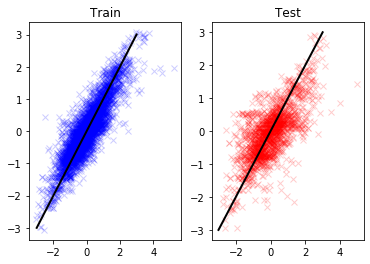

In [54]:
plt.subplot(1, 2, 1)
plt.plot(Y_train, nn.predict(X_train), marker = 'x', color = 'blue', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.plot(Y_test, nn.predict(X_test), marker = 'x', color = 'red', linestyle = 'None', alpha = 0.2)
plt.plot([-3, 3], [-3, 3], color='black', linewidth=2)
plt.title('Test')

### Gaussian process model __GP__
#### _The default parameters_

In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [56]:
gp_reg = GaussianProcessRegressor()
print('Parameters currently in use:\n')
pprint(gp_reg.get_params())

Parameters currently in use:

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}


#### _Optimisation_

In [57]:
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel

The __optimal__ model

Once the model has been optimized, I ran it again with more restarts. The __gp__ object (the model) was run then exported as a joblib file. To avoid fitting the model on each kernel restart, the fitting has been greyed out in favor of an import of the joblib file.

In [58]:
gp_reg = GaussianProcessRegressor(alpha=0.19528574128654064, copy_X_train=True,
                                  kernel=RBF(length_scale=1), n_restarts_optimizer=0,
                                  normalize_y=False, optimizer='fmin_l_bfgs_b',
                                  random_state=None)
gp = gp_reg.fit(X_train, Y_train)

The __gp__ performance in train and test

In [59]:
Y_train_predgp = gp.predict(X_train) * std_respvars.values + mean_respvars.values
Y_test_predgp =  gp.predict(X_test) * std_respvars.values + mean_respvars.values

In [60]:
index = ['Gaussian processes']
gp_scores = pd.DataFrame({"Train_R2": r2_score(Y_train, gp.predict(X_train)).round(3), 
                          "Train_MAE": mean_absolute_error(Y_train_obs, Y_train_predgp).round(2),
                           "Train_RMSE": np.sqrt(mean_squared_error(Y_train_obs, Y_train_predgp)).round(2),
                           "Test_R2": r2_score(Y_test, gp.predict(X_test)).round(3),
                           "Test_MAE": mean_absolute_error(Y_test_obs, Y_test_predgp).round(2),
                           "Test_RMSE": np.sqrt(mean_squared_error(Y_test_obs, Y_test_predgp)).round(2)}, 
                           index = index)
gp_scores

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE
Gaussian processes,0.836,3.06,4.08,0.579,5.1,6.82


The __gp__ ressults plot

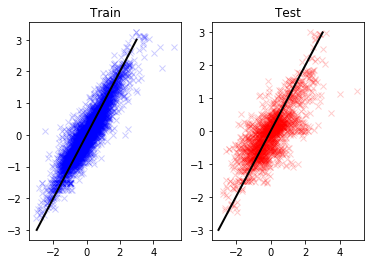

In [61]:
counter = 1
for i in range(len(resp_vars)):
    plt.subplot(len(resp_vars), 2, counter)
    plt.plot(Y_train[:, 0], gp.predict(X_train), marker = 'x', color = 'blue', linestyle = 'None', alpha = 0.2)
    plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
    plt.title('Train')

    plt.subplot(1, 2, counter + 1)
    plt.plot(Y_test[:, 0], gp.predict(X_test), marker = 'x', color = 'red', linestyle = 'None', alpha = 0.2)
    plt.plot([-3, 3], [-3, 3], color = 'black', linewidth = 2)
    plt.title('Test')
    
    counter = counter + 1

This chain concatenates scores of the models including Mitscherlich model (file 2.5_).

In [62]:
mitsch_train_test_scores = pd.read_csv('output/mitsch_train_test_scores.csv')
mitsch_train_test_scores = mitsch_train_test_scores.rename(index = {0: "Mitscherlich"})
scoresYield = pd.concat([mitsch_train_test_scores, knn_scores, rf_scores, nn_scores, gp_scores], axis = 0, ignore_index = False)
scoresYield['Target'] = 'Yield'
scoresYield.to_csv('output/scoresYield.csv')
scoresYield

,Train_R2,Train_MAE,Train_RMSE,Test_R2,Test_MAE,Test_RMSE,Target
Mitscherlich,0.349907,6.225086,8.105052,0.374342,8.324857,10.774794,Yield
k-nearest neighbors,0.917000,1.600000,2.890000,0.521000,5.500000,7.270000,Yield
Random forest,0.898000,2.290000,3.210000,0.592000,5.070000,6.720000,Yield
Neural networks,0.783000,3.540000,4.690000,0.487000,5.570000,7.530000,Yield
Gaussian processes,0.836000,3.060000,4.080000,0.579000,5.100000,6.820000,Yield


### Point estimation: prediction of economic optimal __NPK__ dosage

#### Create a table to model

I sample a random row in the test set and use it as an example where the model is used for diagnosis. The row is referenced by its index. I ensure that the selected trial could be found in the data of the next codes files.

In [63]:
r_sample = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai), 
                        ["NoEssai", "test_type", "ID"]].sample(1, random_state = 765) #765
r_sample.to_csv('output/r_sample.csv')
r_sample

,NoEssai,test_type,ID
2540,194,P,194-2-4


In [64]:
# Verify the row index
index = r_sample.index[0]
index

2540

I grab this row with only the columns I need for modeling from the `df_ml_sc` table, which is already on the right scale for modeling.

In [65]:
reference_row = df_ml_sc.loc[df_ml_sc.index == index, df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]
NoEssai = id_table.loc[df_ml_sc.index == index].NoEssai.values[0]

The optimal economical dose is where the marginal benefit (__= profit from yield - fertilizers cost__) reaches its maximum. Rates are estimated based on experience.

In [66]:
N_cost = 1.2 # unit fertilizer N cost
P_cost = 1.1 # unit fertilizer P2O5 cost
K_cost = 0.9 # unit fertilizer K2O cost
price_yield = 250 # unit crop yield price (1 Mg)

Instead of generating a grid of values (_which is numerically inefficient_), I generate random NPK doses from _uniform distributions_ on plausible doses. The `random.uniform()` function gives a random floating point number in a given range.

In [67]:
n_grid_samples = 1000 # number of samples
N_range = [0, 250]
P_range = [0, 250]
K_range = [0, 250]

np.random.seed(936492)
dose_grid = pd.DataFrame({'NtotDose': np.random.uniform(N_range[0], N_range[1], n_grid_samples),
                          'PtotDose': np.random.uniform(P_range[0], P_range[1], n_grid_samples),
                          'KtotDose': np.random.uniform(K_range[0], K_range[1], n_grid_samples)})

Doses are variables among others, and also need to be scaled on the scale on which they were put in to create the model.

In [68]:
dose_grid_sc = dose_grid.copy()
#dose_vars = dose_grid.columns
for var in dose_vars:
    dose_grid_sc[var] = (dose_grid[var] - mean_numvars[var]) / std_numvars[var]

The last part to create the table is to stack the (_randomly selected_) observation a number of times equal to the __dose_grid__ table length, so that it conveys the same information at each row. Then replace only __NPK__ doses with the one sampled randomly: the __dose_grid__.

In [69]:
reference_stack = pd.DataFrame(index = range(dose_grid.shape[0]), columns = reference_row.columns)
for i in range(reference_stack.shape[1]):
    reference_stack.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack.shape[0])
reference_stack.NtotDose = dose_grid_sc.NtotDose
reference_stack.PtotDose = dose_grid_sc.PtotDose
reference_stack.KtotDose = dose_grid_sc.KtotDose    

Yield is predicted based on the table, then put back to its original scale and inserted in the __dose_grid__ table.

#### Prediction with __knn__ model

In [70]:
yield_sc = knn.predict(reference_stack)
dose_grid["yield_"] = yield_sc[:, 0] * std_respvars.values + mean_respvars.values

I have fertilizer doses, so I can compute the costs. I can also compute revenue from yield, and marginal benefits by subtracting marginal costs from revenue.

In [71]:
dose_grid["cost"] = dose_grid.NtotDose * N_cost + dose_grid.PtotDose * P_cost + dose_grid.KtotDose * K_cost
dose_grid["revenue"] = dose_grid.yield_ * price_yield
dose_grid["benefit"] = dose_grid.revenue - dose_grid.cost

I isolate the row where the marginal benefit is maximum, and its informations.

In [72]:
opt_doses_knn = dose_grid.loc[dose_grid["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
opt_doses_knn

NtotDose      39.85
PtotDose     243.39
KtotDose     144.65
yield_        30.13
benefit     7085.78
Name: 186, dtype: float64

#### Prediction with __rf__ model

In [73]:
yield_sc = rfm.predict(reference_stack)
dose_grid["yield_"] = yield_sc * std_respvars.values + mean_respvars.values # yield_sc specifically not indexed needed with rfm
dose_grid["cost"] = dose_grid.NtotDose * N_cost + dose_grid.PtotDose * P_cost + dose_grid.KtotDose * K_cost
dose_grid["revenue"] = dose_grid.yield_ * price_yield
dose_grid["benefit"] = dose_grid.revenue - dose_grid.cost
opt_doses_rf = dose_grid.loc[dose_grid["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
opt_doses_rf

NtotDose     188.65
PtotDose     245.06
KtotDose      91.64
yield_        31.56
benefit     7312.10
Name: 695, dtype: float64

#### Prediction with __nn__ model

In [74]:
yield_sc = nn.predict(reference_stack)
dose_grid["yield_"] = yield_sc * std_respvars.values + mean_respvars.values # yield_sc specifically not indexed needed with nn
dose_grid["cost"] = dose_grid.NtotDose * N_cost + dose_grid.PtotDose * P_cost + dose_grid.KtotDose * K_cost
dose_grid["revenue"] = dose_grid.yield_ * price_yield
dose_grid["benefit"] = dose_grid.revenue - dose_grid.cost
opt_doses_nn = dose_grid.loc[dose_grid["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
opt_doses_nn

NtotDose      241.56
PtotDose      194.78
KtotDose       14.22
yield_         42.38
benefit     10077.31
Name: 433, dtype: float64

#### Prediction with the __gp__ model

In [75]:
yield_sc = gp.predict(reference_stack)
dose_grid["yield_"] = yield_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid["cost"] = dose_grid.NtotDose * N_cost + dose_grid.PtotDose * P_cost + dose_grid.KtotDose * K_cost
dose_grid["revenue"] = dose_grid.yield_ * price_yield
dose_grid["benefit"] = dose_grid.revenue - dose_grid.cost
opt_doses_gp = dose_grid.loc[dose_grid["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
opt_doses_gp

NtotDose     247.98
PtotDose     146.47
KtotDose      76.84
yield_        33.15
benefit     7758.57
Name: 928, dtype: float64

This chain concatenates the points estimates of the machine learning models, and converts P2O5 and K2O in P and K respectively.

In [76]:
keys = ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]
predYield = pd.DataFrame({"k-nearest neighbors": opt_doses_knn,
                       "Random forest": opt_doses_rf,
                       "Neural networks": opt_doses_nn,
                       "Gaussian processes": opt_doses_gp},
                      index = keys).T
predYield['PtotDose'] = predYield.PtotDose*0.436
predYield['KtotDose'] = predYield.KtotDose*0.830
predYield['Target'] = "Yield"
predYield = predYield.rename(columns = {"yield_":"Output"})
predYield.drop(['benefit'], axis = 1).to_csv('output/predYield.csv')
predYield

,NtotDose,PtotDose,KtotDose,Output,benefit,Target
k-nearest neighbors,39.85,106.11804,120.0595,30.13,7085.78,Yield
Random forest,188.65,106.84616,76.0612,31.56,7312.10,Yield
Neural networks,241.56,84.92408,11.8026,42.38,10077.31,Yield
Gaussian processes,247.98,63.86092,63.7772,33.15,7758.57,Yield


### NPK doses according to the CRAAQ fertilisation guide

- Nitrogen:
1. Soil textural groupe G2: 125 - 150 kg N/ha
2. Soil textural groupe G3: 135 - 175 kg N/ha
- Phosphorous:

In [77]:
pd.DataFrame({"ISP1": soil_table.loc[df_ml_sc.index == index, ["ISP1"]].values[0],
              "P Dose": 0.436*craaq_P(soil_table.loc[df_ml_sc.index == index, ["ISP1"]].values)})

,ISP1,P Dose
0,1.428119,87.2


- Potassium:

In [78]:
pd.DataFrame({"soil_K": soil_table.loc[df_ml_sc.index == index, ["soil_K"]].values[0],
              "K Dose": 0.830*craaq_K(soil_table.loc[df_ml_sc.index == index, ["soil_K"]].values)})

,soil_K,K Dose
0,83.11,178.45


### Prediction specific to trial type

I randomly select different test type (N, P, K) trials and plot their responses to compare the goodness of fit of the four models. The same codes are repeated for each element to generate new tables, one for each dose type. The treatment element varied while the others are kept constant at their experimental dosage.

Reference trial where only __N__ dose varied: `(test_type = N)`

In [79]:
id_n = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)]
id_n.index = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)].index
id_sample_n = id_n.loc[id_n.test_type=="N", ["NoEssai", "test_type", "ID"]].sample(1, random_state = 543) #543
id_sample_n

,NoEssai,test_type,ID
1745,8804,N,8804-5-5


In [80]:
reference_row_N = df_ml_sc.loc[df_ml_sc.index == id_sample_n.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]
dose_grid_N = pd.DataFrame({'NtotDose': np.linspace(0, 250, 251),
                            'PtotDose': reference_row_N.PtotDose.values[0],
                            'KtotDose': reference_row_N.KtotDose.values[0]})

dose_grid_N_sc = dose_grid_N.copy()
for var in dose_vars:
    dose_grid_N_sc[var] = (dose_grid_N[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_N = pd.DataFrame(index = range(dose_grid_N.shape[0]), columns = reference_row_N.columns)
for i in range(reference_stack_N.shape[1]):
    reference_stack_N.iloc[:, i] = np.repeat(reference_row_N.values[0, i], reference_stack_N.shape[0])
reference_stack_N.NtotDose = dose_grid_N_sc.NtotDose
reference_stack_N.PtotDose = dose_grid_N_sc.PtotDose
reference_stack_N.KtotDose = dose_grid_N_sc.KtotDose  

In [81]:
# Point estimate
knn_N_sc = knn.predict(reference_stack_N)
rf_N_sc = rfm.predict(reference_stack_N)
nn_N_sc = nn.predict(reference_stack_N)
gp_N_sc = gp.predict(reference_stack_N)

dose_grid_N["yield_knn"] = knn_N_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_N["yield_rf"] = rf_N_sc * std_respvars.values + mean_respvars.values
dose_grid_N["yield_nn"] = nn_N_sc * std_respvars.values + mean_respvars.values
dose_grid_N["yield_gp"] = gp_N_sc[:, 0] * std_respvars.values + mean_respvars.values
# seul N variant, on peut estimer le coût de l'engrais en fonction de N seul
dose_grid_N["cost"] = dose_grid_N.NtotDose * N_cost 
# le revenu varie selon le modèle, et donc le benefice aussi
dose_grid_N["gp_revenue"] = dose_grid_N.yield_gp * price_yield
dose_grid_N["gp_benefit"] = dose_grid_N.gp_revenue - dose_grid_N.cost
doses_opt_N_point = dose_grid_N.loc[dose_grid_N["gp_benefit"].idxmax(), ["NtotDose", "yield_gp", "gp_benefit"]].round(2)
Ndata = df_ml.loc[id_table.NoEssai == id_sample_n.NoEssai.values[0]][["RendVendable", "NtotDose"]]

Reference trial where only __P__ dose varied: `(test_type = P)`

In [82]:
id_p = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)]
id_p.index = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)].index
id_sample_p = id_p.loc[id_p.test_type=="P", ["NoEssai", "test_type", "ID"]].sample(1, random_state = 7654) #7654
id_sample_p

,NoEssai,test_type,ID
5524,412,P,412-3-4


In [83]:
#Pdata = df_ml.loc[id_table.NoEssai == id_sample_p.NoEssai.values[0]][["RendVendable", "PtotDose"]]
#plt.plot(Pdata.PtotDose, Pdata.RendVendable, "o")

In [84]:
reference_row_P = df_ml_sc.loc[df_ml_sc.index == id_sample_p.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]

dose_grid_P = pd.DataFrame({'NtotDose': reference_row_P.NtotDose.values[0],
                          'PtotDose': np.linspace(0, 250, 251),
                          'KtotDose': reference_row_P.KtotDose.values[0]})
dose_grid_P['P'] = 0.436*dose_grid_P.PtotDose

dose_grid_P_sc = dose_grid_P.copy()
for var in dose_vars:
    dose_grid_P_sc[var] = (dose_grid_P[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_P = pd.DataFrame(index = range(dose_grid_P.shape[0]), columns = reference_row_P.columns)
for i in range(reference_stack_P.shape[1]):
    reference_stack_P.iloc[:, i] = np.repeat(reference_row_P.values[0, i], reference_stack_P.shape[0])
reference_stack_P.NtotDose = dose_grid_P_sc.NtotDose
reference_stack_P.PtotDose = dose_grid_P_sc.PtotDose
reference_stack_P.KtotDose = dose_grid_P_sc.KtotDose  

In [85]:
# Point estimate
knn_P_sc = knn.predict(reference_stack_P)
rf_P_sc = rfm.predict(reference_stack_P)
nn_P_sc = nn.predict(reference_stack_P)
gp_P_sc = gp.predict(reference_stack_P)

dose_grid_P["yield_knn"] = knn_P_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_P["yield_rf"] = rf_P_sc * std_respvars.values + mean_respvars.values
dose_grid_P["yield_nn"] = nn_P_sc * std_respvars.values + mean_respvars.values
dose_grid_P["yield_gp"] = gp_P_sc[:, 0] * std_respvars.values + mean_respvars.values
# seul P variant, on peut estimer le coût de l'engrais en fonction P seul
dose_grid_P["cost"] = dose_grid_P.PtotDose * P_cost 
# le revenu varie selon le modèle, et donc le benefice aussi
dose_grid_P["gp_revenue"] = dose_grid_P.yield_gp * price_yield
dose_grid_P["gp_benefit"] = dose_grid_P.gp_revenue - dose_grid_P.cost
doses_opt_P_point = dose_grid_P.loc[dose_grid_P["gp_benefit"].idxmax(), ["PtotDose", "yield_gp", "gp_benefit"]].round(2)
Pdata = df_ml.loc[id_table.NoEssai == id_sample_p.NoEssai.values[0]][["RendVendable", "PtotDose"]]
Pdata['P'] = 0.436*Pdata.PtotDose

Reference trial where only __K__ dose varied: `(test_type = K)`

In [86]:
id_k = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)]
id_k.index = id_table.loc[blocks.isin(blocks_inTest) & id_table.NoEssai.isin(common_df.NoEssai)].index
id_sample_k = id_k.loc[id_k.test_type=="K", ["NoEssai", "test_type", "ID"]].sample(1, random_state = 6123) #6123
id_sample_k

,NoEssai,test_type,ID
3843,320,K,320-3-3


In [87]:
#Kdata = df_ml.loc[id_table.NoEssai == id_sample_k.NoEssai.values[0]][["RendVendable", "KtotDose"]]
#plt.plot(Kdata.KtotDose, Kdata.RendVendable, "o")

In [88]:
reference_row_K = df_ml_sc.loc[df_ml_sc.index == id_sample_k.index[0], 
                               df_ml.columns.isin(num_vars)]# | df_ml.columns.str.startswith(cat_vars[0])]

dose_grid_K = pd.DataFrame({'NtotDose': reference_row_K.NtotDose.values[0],
                           'PtotDose': reference_row_K.PtotDose.values[0],
                           'KtotDose': np.linspace(0, 250, 251)})
dose_grid_K['K'] = 0.830*dose_grid_K.KtotDose

dose_grid_K_sc = dose_grid_K.copy()
for var in dose_vars:
    dose_grid_K_sc[var] = (dose_grid_K[var] - mean_numvars[var]) / std_numvars[var]

reference_stack_K = pd.DataFrame(index = range(dose_grid_K.shape[0]), columns = reference_row_K.columns)
for i in range(reference_stack_K.shape[1]):
    reference_stack_K.iloc[:, i] = np.repeat(reference_row_K.values[0, i], reference_stack_K.shape[0])
reference_stack_K.NtotDose = dose_grid_K_sc.NtotDose
reference_stack_K.PtotDose = dose_grid_K_sc.PtotDose
reference_stack_K.KtotDose = dose_grid_K_sc.KtotDose  

In [89]:
# Point estimate
knn_K_sc = knn.predict(reference_stack_K)
rf_K_sc = rfm.predict(reference_stack_K)
nn_K_sc = nn.predict(reference_stack_K)
gp_K_sc = gp.predict(reference_stack_K)

dose_grid_K["yield_knn"] = knn_K_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_K["yield_rf"] = rf_K_sc * std_respvars.values + mean_respvars.values
dose_grid_K["yield_nn"] = nn_K_sc * std_respvars.values + mean_respvars.values
dose_grid_K["yield_gp"] = gp_K_sc[:, 0] * std_respvars.values + mean_respvars.values
# seul K variant, on peut estimer le coût de l'engrais en fonction de K seul
dose_grid_K["cost"] = dose_grid_K.KtotDose * K_cost 
# le revenu varie selon le modèle, et donc le benefice aussi
dose_grid_K["gp_revenue"] = dose_grid_K.yield_gp * price_yield
dose_grid_K["gp_benefit"] = dose_grid_K.gp_revenue - dose_grid_K.cost
doses_opt_K_point = dose_grid_K.loc[dose_grid_K["gp_benefit"].idxmax(), ["KtotDose", "yield_gp", "gp_benefit"]].round(2)
Kdata = df_ml.loc[id_table.NoEssai == id_sample_k.NoEssai.values[0]][["RendVendable", "KtotDose"]]
Kdata['K'] = 0.830*Kdata.KtotDose

In [90]:
# Save selected trials for R
pd.concat([id_sample_n, id_sample_p, id_sample_k], axis=0, ignore_index=False).to_csv('output/test_types.csv')

### Output data for future visualisation

The results are saved in the `output` folder and are loaded in the vizualisation notebook.

In [91]:
Ndata["Sample"] = id_sample_n.NoEssai.values[0]
Pdata["Sample"] = id_sample_p.NoEssai.values[0]
Kdata["Sample"] = id_sample_k.NoEssai.values[0]

Ndata.to_csv("output/yield_model_Ndata.csv")
Pdata.to_csv("output/yield_model_Pdata.csv")
Kdata.to_csv("output/yield_model_Kdata.csv")

dose_grid_N.to_csv("output/yield_model_N.csv")
dose_grid_P.to_csv("output/yield_model_P.csv")
dose_grid_K.to_csv("output/yield_model_K.csv")

### Probabilistic prediction with gaussian process

One advantage of gaussian processes is that it's probabilistic: it doesn't only returns point estimates, but can returns posterior samples. For the demonstration of this section, I use the `reference_stack` data frame. I generate `500` gaussian process samples for each `NPK` triplet from the random doses `dose_grid` used for initial point estimation.

In [92]:
n_gp_samples = 500
gp_samples_sc = gp.sample_y(reference_stack, n_samples = n_gp_samples)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

... and put predicted yields back to scale.

In [93]:
gp_samples = gp_samples_sc.copy()
for i in range(n_gp_samples):
    gp_samples[:, i] = gp_samples_sc[:, i] * std_respvars.values + mean_respvars.values

Gaussian process samples are put in a pandas data frame with pretty column names.

In [94]:
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])
gp_yields = pd.DataFrame(gp_samples, columns = gp_names)

Yields are proportional to gains.

In [95]:
gp_revenue = gp_yields * price_yield
gp_benefit = gp_revenue.apply(func = lambda x: x - dose_grid["cost"], axis = 0)

Then, for each gaussian process, I find the optimal economical dosage. The optimal dosages are gathered in a pandas data frame. The corresponding yield and benefit are also reported.

In [96]:
doses_opt = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "yield_":0, "benefit":0}, index = gp_names)
for i in gp_names:
    doses_opt.loc[i] = dose_grid.loc[gp_benefit.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]]
doses_opt['P'] = 0.436*doses_opt.PtotDose
doses_opt['K'] = 0.830*doses_opt.KtotDose

This chain plots the distribution of each fertilizer optimal doses of the same trial (_the randomly selected one `r_sample`_). The red dotted vertical lines show the optimal dosage from the initial gaussian process point estimate.

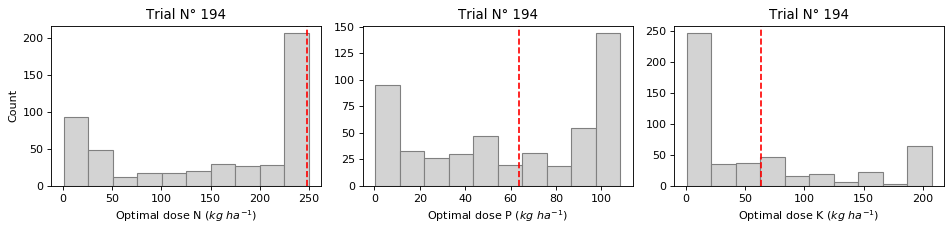

In [131]:
plt.figure(figsize=(12, 3), dpi= 80, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 3, 
                       width_ratios=[1,1,1],
                       height_ratios=[1]
                      ) 
ax0 = plt.subplot(gs[0])
ax0.hist(doses_opt.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax0.axvline(x = opt_doses_gp[0], color = 'r', linestyle = '--')
ax0.set_title("Trial N° " + str(NoEssai))
ax0.set_xlabel(r"Optimal dose N ($kg~ha^{-1})$")
ax0.set_ylabel("Count")

ax1 = plt.subplot(gs[1])
ax1.hist(doses_opt.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax1.axvline(x = 0.436*opt_doses_gp[1], color = 'r', linestyle = '--')
ax1.set_title("Trial N° " + str(NoEssai))
ax1.set_xlabel(r"Optimal dose P ($kg~ha^{-1})$")

ax2 = plt.subplot(gs[2])
ax2.hist(doses_opt.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax2.axvline(x = 0.830*opt_doses_gp[2], color = 'r', linestyle = '--')
ax2.set_title("Trial N° " + str(NoEssai))
ax2.set_xlabel(r"Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout()

These distributions show optimal doses (_most of the time_) on the edge of ranges. How can we use this model for decision making while it's difficult to obtain credible optimal dosage? Using the same trial, I generate new tables, one for each fertilizer type, and where one dose is varying while the others are kept constant _at their __gp__ model computed optimum_.

#### Prediction where only __N__ dosage varied, trial `r_sample`

In [132]:
dose_grid_N = pd.DataFrame({'NtotDose': np.linspace(0, 250, 251),
                          'PtotDose': opt_doses_gp.PtotDose,
                          'KtotDose': opt_doses_gp.KtotDose})

In [133]:
dose_grid_N_sc = dose_grid_N.copy()
for var in dose_vars:
    dose_grid_N_sc[var] = (dose_grid_N[var] - mean_numvars[var]) / std_numvars[var]

In [134]:
reference_stack_N = pd.DataFrame(index = range(dose_grid_N.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_N.shape[1]):
    reference_stack_N.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_N.shape[0])
reference_stack_N.NtotDose = dose_grid_N_sc.NtotDose
reference_stack_N.PtotDose = dose_grid_N_sc.PtotDose
reference_stack_N.KtotDose = dose_grid_N_sc.KtotDose  

Point estimate

In [135]:
yield_N_sc = gp.predict(reference_stack_N)
dose_grid_N["yield_"] = yield_N_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_N["cost"] = dose_grid_N.NtotDose * N_cost + dose_grid_N.PtotDose * P_cost + dose_grid_N.KtotDose * K_cost
dose_grid_N["revenue"] = dose_grid_N.yield_ * price_yield
dose_grid_N["benefit"] = dose_grid_N.revenue - dose_grid_N.cost
doses_opt_N_point = dose_grid_N.loc[dose_grid_N["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)

GP samples

In [136]:
n_gp_samples = 5
gp_samples_N_sc = gp.sample_y(reference_stack_N, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_N = gp_samples_N_sc.copy()
for i in range(n_gp_samples):
    gp_samples_N[:, i] = gp_samples_N_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])
gp_yields_N = pd.DataFrame(gp_samples_N, columns = gp_names)

# Revenues and benefits
gp_revenue_N = gp_yields_N * price_yield
gp_benefit_N = gp_revenue_N.apply(func = lambda x: x - dose_grid_N["cost"], axis = 0)

# N optimal dosages
doses_opt_N_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_N_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_N.loc[gp_benefit_N.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_N_samples.loc[i, "yield_"] = gp_yields_N.loc[gp_benefit_N.loc[:, i].idxmax(), i]

#### Prediction where only __P__ dosage varied, trial `r_sample`

In [137]:
dose_grid_P = pd.DataFrame({'NtotDose': opt_doses_gp.NtotDose,
                          'PtotDose': np.linspace(0, 250, 251),
                          'KtotDose': opt_doses_gp.KtotDose})

In [138]:
dose_grid_P_sc = dose_grid_P.copy()
for var in dose_vars:
    dose_grid_P_sc[var] = (dose_grid_P[var] - mean_numvars[var]) / std_numvars[var]

In [139]:
reference_stack_P = pd.DataFrame(index = range(dose_grid_P.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_P.shape[1]):
    reference_stack_P.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_P.shape[0])
reference_stack_P.NtotDose = dose_grid_P_sc.NtotDose
reference_stack_P.PtotDose = dose_grid_P_sc.PtotDose
reference_stack_P.KtotDose = dose_grid_P_sc.KtotDose  

Point estimate

In [140]:
yield_P_sc = gp.predict(reference_stack_P)
dose_grid_P["yield_"] = yield_P_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_P["cost"] = dose_grid_P.NtotDose * N_cost + dose_grid_P.PtotDose * P_cost + dose_grid_P.KtotDose * K_cost
dose_grid_P["revenue"] = dose_grid_P.yield_ * price_yield
dose_grid_P["benefit"] = dose_grid_P.revenue - dose_grid_P.cost
dose_grid_P['P'] = 0.436*dose_grid_P.PtotDose
doses_opt_P_point = dose_grid_P.loc[dose_grid_P["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
doses_opt_P_point['P'] = 0.436*doses_opt_P_point.PtotDose

GP samples

In [141]:
n_gp_samples = 5
gp_samples_P_sc = gp.sample_y(reference_stack_P, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_P = gp_samples_P_sc.copy()
for i in range(n_gp_samples):
    gp_samples_P[:, i] = gp_samples_P_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])
gp_yields_P = pd.DataFrame(gp_samples_P, columns = gp_names)

# Revenues and benefits
gp_revenue_P = gp_yields_P * price_yield
gp_benefit_P = gp_revenue_P.apply(func = lambda x: x - dose_grid_P["cost"], axis = 0)

# P optimal dosages
doses_opt_P_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_P_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_P.loc[gp_benefit_P.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_P_samples.loc[i, "yield_"] = gp_yields_P.loc[gp_benefit_P.loc[:, i].idxmax(), i]
doses_opt_P_samples["P"] = 0.436*doses_opt_P_samples.PtotDose

#### Prediction where only __K__ dosage varied, trial `r_sample`

In [142]:
dose_grid_K = pd.DataFrame({'NtotDose': opt_doses_gp.NtotDose,
                          'PtotDose': opt_doses_gp.PtotDose,
                          'KtotDose': np.linspace(0, 250, 251)})

In [143]:
dose_grid_K_sc = dose_grid_K.copy()
for var in dose_vars:
    dose_grid_K_sc[var] = (dose_grid_K[var] - mean_numvars[var]) / std_numvars[var]

In [144]:
reference_stack_K = pd.DataFrame(index = range(dose_grid_K.shape[0]), columns = reference_row.columns)
for i in range(reference_stack_K.shape[1]):
    reference_stack_K.iloc[:, i] = np.repeat(reference_row.values[0, i], reference_stack_K.shape[0])
reference_stack_K.NtotDose = dose_grid_K_sc.NtotDose
reference_stack_K.PtotDose = dose_grid_K_sc.PtotDose
reference_stack_K.KtotDose = dose_grid_K_sc.KtotDose  

Point estimate

In [145]:
yield_K_sc = gp.predict(reference_stack_K)
dose_grid_K["yield_"] = yield_K_sc[:, 0] * std_respvars.values + mean_respvars.values
dose_grid_K["cost"] = dose_grid_K.NtotDose * N_cost + dose_grid_K.PtotDose * P_cost + dose_grid_K.KtotDose * K_cost
dose_grid_K["revenue"] = dose_grid_K.yield_ * price_yield
dose_grid_K["benefit"] = dose_grid_K.revenue - dose_grid_K.cost
dose_grid_K['K'] = 0.830*dose_grid_K.KtotDose
doses_opt_K_point = dose_grid_K.loc[dose_grid_K["benefit"].idxmax(), ["NtotDose", "PtotDose", "KtotDose", "yield_", "benefit"]].round(2)
doses_opt_K_point['K'] = 0.830*doses_opt_K_point.KtotDose

GP samples

In [146]:
n_gp_samples = 5
gp_samples_K_sc = gp.sample_y(reference_stack_K, n_samples = n_gp_samples, random_state = 615108)[:, 0, :] # [:, 0, :] to remove dummy middle dimension

# Scale back to original
gp_samples_K = gp_samples_K_sc.copy()
for i in range(n_gp_samples):
    gp_samples_K[:, i] = gp_samples_K_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])
gp_yields_K = pd.DataFrame(gp_samples_K, columns = gp_names)

# Revenues and benefits
gp_revenue_K = gp_yields_K * price_yield
gp_benefit_K = gp_revenue_K.apply(func = lambda x: x - dose_grid_K["cost"], axis = 0)

# K optimal dosages
doses_opt_K_samples = pd.DataFrame({"NtotDose":0, "PtotDose":0, "KtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_K_samples.loc[i, ["NtotDose", "PtotDose", "KtotDose"]] = dose_grid_K.loc[gp_benefit_K.loc[:, i].idxmax(), ["NtotDose", "PtotDose", "KtotDose"]]
    doses_opt_K_samples.loc[i, "yield_"] = gp_yields_K.loc[gp_benefit_K.loc[:, i].idxmax(), i]
doses_opt_K_samples["K"] = 0.830*doses_opt_K_samples.KtotDose

#### Plots of all cases

Results are presented as the average GP and its point optimal dose in blue, with `5` gaussian processes and their optimal. Histograms of probabilistic optimal doses are shown under the response curves.

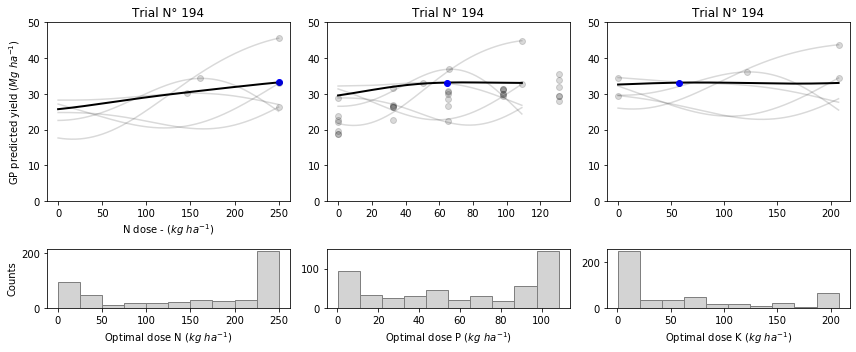

In [147]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1]) 

# N
ax0 = plt.subplot(gs[0])
ax0.plot(dose_grid_N.NtotDose, dose_grid_N.yield_, linewidth = 2, color = "black")
ax0.plot(doses_opt_N_point.NtotDose, doses_opt_N_point.yield_, marker = "o", color = "blue")
for i in gp_yields_N.columns:
    ax0.plot(dose_grid_N.NtotDose, gp_yields_N[i], color = "black", alpha=0.15)
    ax0.plot(doses_opt_N_samples.loc[i, "NtotDose"], doses_opt_N_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
if r_sample.test_type.values[0] == "N":
    plot_Ndata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["RendVendable", "NtotDose"]]
    plt.plot(plot_Ndata.NtotDose, plot_Ndata.RendVendable, "o", color = "black", alpha = 0.15)
ax0.set_ylim([0, 50])
ax0.set_xlabel("N dose - ($kg~ha^{-1})$")
ax0.set_ylabel("GP predicted yield ($Mg~ha^{-1})$")
ax0.set_title("Trial N° " + str(NoEssai))

ax1 = plt.subplot(gs[3])
ax1.hist(doses_opt.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax1.set_xlabel("Optimal dose N ($kg~ha^{-1})$")
ax1.set_ylabel("Counts")

# P
ax2 = plt.subplot(gs[1])
ax2.plot(dose_grid_P.P, dose_grid_P.yield_, linewidth = 2, color = "black")
ax2.plot(doses_opt_P_point.P, doses_opt_P_point.yield_, marker = "o", color = "blue")
for i in gp_yields_P.columns:
    ax2.plot(dose_grid_P.P, gp_yields_P[i], color = "black", alpha=0.15)
    ax2.plot(doses_opt_P_samples.loc[i, "P"], doses_opt_P_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
if r_sample.test_type.values[0] == "P":
    plot_Pdata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["RendVendable", "PtotDose"]]
    plot_Pdata['P'] = 0.436*plot_Pdata.PtotDose
    plt.plot(plot_Pdata.P, plot_Pdata.RendVendable, "o", color = "black", alpha = 0.15)   
ax2.set_ylim([0, 50])
ax2.set_title("Trial N° " + str(NoEssai))

ax3 = plt.subplot(gs[4])
ax3.hist(doses_opt.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax3.set_xlabel(r"Optimal dose P ($kg~ha^{-1})$")

# K
ax4 = plt.subplot(gs[2])
ax4.plot(dose_grid_K.K, dose_grid_K.yield_, linewidth = 2, color = "black")
ax4.plot(doses_opt_K_point.K, doses_opt_K_point.yield_, marker = "o", color = "blue")
for i in gp_yields_K.columns:
    ax4.plot(dose_grid_K.K, gp_yields_K[i], color = "black", alpha=0.15)
    ax4.plot(doses_opt_K_samples.loc[i, "K"], doses_opt_K_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
if r_sample.test_type.values[0] == "K":
    plot_Kdata = df_ml.loc[id_table.NoEssai == r_sample.NoEssai.values[0]][["RendVendable", "KtotDose"]]
    plot_Kdata['K'] = 0.830*plot_Kdata.KtotDose
    plt.plot(plot_Kdata.K, plot_Kdata.RendVendable, "o", color = "black", alpha = 0.15)   
ax4.set_ylim([0, 50])
ax4.set_title("Trial N° " + str(NoEssai))

ax5 = plt.subplot(gs[5])
ax5.hist(doses_opt.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax5.set_xlabel(r"Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout();

The distributions are almost similar to those from the uniform random grid doses table. Probabilistic optimum are on the edges of ranges corresponding or not to the prior optimum (_black point_).

### Probabilistic predictions based on __trial type__
These chains make probabilistic predictions for the three N, P and K trials already modeled using `id_sample_n`, `id_sample_p` and `id_sample_k` respectively.

In [148]:
# GP samples for the N trial
n_gp_samples = 1000 # 500
gp_samples_N_sc = gp.sample_y(reference_stack_N, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_N = gp_samples_N_sc.copy()
for i in range(n_gp_samples):
    gp_samples_N[:, i] = gp_samples_N_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_yields_N = pd.DataFrame(gp_samples_N, columns = gp_names)

gp_revenue_N = gp_yields_N * price_yield
gp_benefit_N = gp_revenue_N.apply(func = lambda x: x - dose_grid_N["cost"], axis = 0)

doses_opt_N_samples = pd.DataFrame({"NtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_N_samples.loc[i, ["NtotDose"]] = dose_grid_N.loc[gp_benefit_N.loc[:, i].idxmax(), ["NtotDose"]]
    doses_opt_N_samples.loc[i, "yield_"] = gp_yields_N.loc[gp_benefit_N.loc[:, i].idxmax(), i]

In [149]:
# GP samples for the P trial
n_gp_samples = 1000 # 500
gp_samples_P_sc = gp.sample_y(reference_stack_P, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_P = gp_samples_P_sc.copy()
for i in range(n_gp_samples):
    gp_samples_P[:, i] = gp_samples_P_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_yields_P = pd.DataFrame(gp_samples_P, columns = gp_names)

gp_revenue_P = gp_yields_P * price_yield
gp_benefit_P = gp_revenue_P.apply(func = lambda x: x - dose_grid_P["cost"], axis = 0)

doses_opt_P_samples = pd.DataFrame({"PtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_P_samples.loc[i, ["PtotDose"]] = dose_grid_P.loc[gp_benefit_P.loc[:, i].idxmax(), ["PtotDose"]]
    doses_opt_P_samples.loc[i, "yield_"] = gp_yields_P.loc[gp_benefit_P.loc[:, i].idxmax(), i]
doses_opt_P_samples["P"] = 0.436*doses_opt_P_samples.PtotDose

In [150]:
# GP samples for the K trial
n_gp_samples = 1000 # 500
gp_samples_K_sc = gp.sample_y(reference_stack_K, n_samples = n_gp_samples, random_state = 615108)[:, 0, :]

# Scale back to original
gp_samples_K = gp_samples_K_sc.copy()
for i in range(n_gp_samples):
    gp_samples_K[:, i] = gp_samples_K_sc[:, i] * std_respvars.values + mean_respvars.values

# Pretty table
gp_names = list(range(n_gp_samples))
for i in range(n_gp_samples):
    gp_names[i] = "gp" + str(gp_names[i])

gp_yields_K = pd.DataFrame(gp_samples_K, columns = gp_names)

gp_revenue_K = gp_yields_K * price_yield
gp_benefit_K = gp_revenue_K.apply(func = lambda x: x - dose_grid_K["cost"], axis = 0)

doses_opt_K_samples = pd.DataFrame({"KtotDose":0, "yield_": 0}, index = gp_names)
for i in gp_names:
    doses_opt_K_samples.loc[i, ["KtotDose"]] = dose_grid_K.loc[gp_benefit_K.loc[:, i].idxmax(), ["KtotDose"]]
    doses_opt_K_samples.loc[i, "yield_"] = gp_yields_K.loc[gp_benefit_K.loc[:, i].idxmax(), i]
doses_opt_K_samples["K"] = 0.830*doses_opt_K_samples.KtotDose

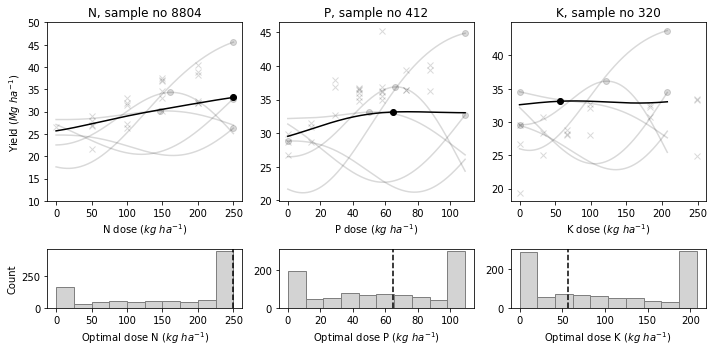

In [151]:
fig = plt.figure(figsize = (10, 5))
gs = gridspec.GridSpec(2, 3, 
                       width_ratios = [1, 1, 1],
                       height_ratios = [3, 1]
                      ) 
# N
ax0 = plt.subplot(gs[0])
ax0.plot(dose_grid_N.NtotDose, dose_grid_N.yield_, "-", color = "black")
ax0.plot(Ndata.NtotDose, Ndata.RendVendable, "x", color = "black", alpha = 0.15)
ax0.plot(doses_opt_N_point.NtotDose, doses_opt_N_point.yield_, marker = "o", color = "black")
for i in gp_yields_N.columns[0:5]:
    ax0.plot(dose_grid_N.NtotDose, gp_yields_N[i], color = "black", alpha=0.15)
    ax0.plot(doses_opt_N_samples.loc[i, "NtotDose"], doses_opt_N_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
ax0.set_ylim([10, 50])
ax0.set_xlabel(r"N dose ($kg~ha^{-1})$")
ax0.set_ylabel(r"Yield ($Mg~ha^{-1})$")
ax0.set_title("N, sample no " + str(id_sample_n.NoEssai.values[0]))

ax1 = plt.subplot(gs[3])
ax1.hist(doses_opt_N_samples.loc[:, "NtotDose"], color = "lightgrey", edgecolor = 'grey')
ax1.axvline(x = doses_opt_N_point.NtotDose, color = 'black', linestyle = '--')
ax1.set_xlabel(r"Optimal dose N ($kg~ha^{-1})$")
ax1.set_ylabel("Count")

# P
ax2 = plt.subplot(gs[1])
ax2.plot(dose_grid_P.P, dose_grid_P.yield_, "-", color = "black")
ax2.plot(Pdata.P, Pdata.RendVendable, "x", color = "black", alpha = 0.15)
ax2.plot(doses_opt_P_point.P, doses_opt_P_point.yield_, marker = "o", color = "black")
for i in gp_yields_P.columns[0:5]:
    ax2.plot(dose_grid_P.P, gp_yields_P[i], color = "black", alpha=0.15)
    ax2.plot(doses_opt_P_samples.loc[i, "P"], doses_opt_P_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
ax2.set_xlabel(r"P dose ($kg~ha^{-1})$")
ax2.set_title("P, sample no " + str(id_sample_p.NoEssai.values[0]))

ax3 = plt.subplot(gs[4])
ax3.hist(doses_opt_P_samples.loc[:, "P"], color = "lightgrey", edgecolor = 'grey')
ax3.axvline(x = doses_opt_P_point.P, color = 'black', linestyle = '--')
ax3.set_xlabel(r"Optimal dose P ($kg~ha^{-1})$")

# K
ax4 = plt.subplot(gs[2])
ax4.plot(dose_grid_K.K, dose_grid_K.yield_, "-", color = "black")
ax4.plot(Kdata.K, Kdata.RendVendable, "x", color = "black", alpha = 0.15)
ax4.plot(doses_opt_K_point.K, doses_opt_K_point.yield_, marker = "o", color = "black")
for i in gp_yields_K.columns[0:5]:
    ax4.plot(dose_grid_K.K, gp_yields_K[i], color = "black", alpha=0.15)
    ax4.plot(doses_opt_K_samples.loc[i, "K"], doses_opt_K_samples.loc[i, "yield_"],
             marker = "o", color = "black", alpha = 0.15)
ax4.set_xlabel(r"K dose ($kg~ha^{-1})$")
ax4.set_title("K, sample no " + str(id_sample_k.NoEssai.values[0]))

ax5 = plt.subplot(gs[5])
ax5.hist(doses_opt_K_samples.loc[:, "K"], color = "lightgrey", edgecolor = 'grey')
ax5.axvline(x = doses_opt_K_point.K, color = 'black', linestyle = '--')
ax5.set_xlabel(r"Optimal dose K ($kg~ha^{-1})$")

plt.tight_layout();
plt.savefig("images/yield_probab_doses.png", bbox_inches ='tight', dpi = 300)

In [152]:
index = ["NtotDose", "PtotDose", "KtotDose", "yield_"]
opt_points = pd.DataFrame({"N trial": doses_opt_N_point,
                           "P trial": doses_opt_P_point,
                           "K trial": doses_opt_K_point},
                          index = index)
opt_points.T

,NtotDose,PtotDose,KtotDose,yield_
N trial,250.00,146.47,76.84,33.19
P trial,247.98,148.00,76.84,33.15
K trial,247.98,146.47,69.00,33.12


In [113]:
perc = np.arange(25, 85, 5)
perc_grid = pd.DataFrame({'perc': perc, 
                          'perc_dose': np.quantile(doses_opt_N_samples.loc[:, "NtotDose"], perc/100).round(0)})

In [114]:
perc_grid = dose_grid_N.loc[dose_grid_N.NtotDose.isin(perc_grid.perc_dose), ["NtotDose", "yield_", "benefit"]].round(2)
perc_grid['difference_from_opt_yield'] = np.abs(doses_opt_N_point[3] - perc_grid.yield_)
perc_grid['difference_from_max_benefit'] = np.abs(doses_opt_N_point[4] - perc_grid.benefit)
perc_grid.index = perc[:perc_grid.shape[0]]
#perc_grid.NtotDose = perc_grid.NtotDose.astype(int)
perc_grid

,NtotDose,yield_,benefit,difference_from_opt_yield,difference_from_max_benefit
25,82.0,28.41,6772.63,4.78,995.18
30,102.0,29.08,6916.18,4.11,851.63
35,127.0,29.86,7081.21,3.33,686.60
40,153.0,30.61,7239.15,2.58,528.66
45,176.0,31.26,7372.45,1.93,395.36
50,203.0,32.00,7524.99,1.19,242.82
55,223.0,32.53,7633.86,0.66,133.95
60,250.0,33.19,7767.81,0.00,0.00
